# Demonstration book for Simplified Music NSF

This is the demonstration book for Simplified Music NSF. It uses the same set of building blocks as Hn-NSF, but it is different and simpler:
1. Only single harmonic branch
2. No low- and high-pass filters
3. Uses more harmonic overtones in the source module

This Simplified Music NSF is thus different from the NSF in [this paper](https://arxiv.org/abs/1910.12381). 
The one in the paper is about transferring Hn-NSF from speech to music, and it directly uses the Hn-NSF for music generation. However, it is not necessary to use Hn-NSF since music is somewhat different from speech signals.

By using this book, we are going to 

* Define a Simplified Music NSF based on function blocks such as 1D CNN, sine waveform generator
* Load pre-trained Music NSF model and generate waveform samples


## 1. Define Simplified Music NSF model

Same as other NSF models, the Simplified Music NSF has three modules.


### 1.1 Preparation

Let's load the packages and basic NN functions:

In [1]:
# At the begining, let's load packages 
from __future__ import absolute_import
from __future__ import print_function
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# load the basic function blocks
import data_models.pre_trained_music_nsf.model as nii_nn_blocks

# misc functions for this demonstration book
import plot_lib
import tool_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

All the necessary NN function blocks are defined in *data_models/pre_trained_music_nsf/model.py*


### 1.2 Condition module

It is the same as the condition module in s1_demonstration_hn-nsf.ipynb.

This condition module in Simplified Music NSF has two specific goals: 
1. Up-sample the input F0 sequence
2. Transform and upsample the input acoustic features (e.g., Mel-spec, and F0)

#### Module definition

In [2]:
class CondModule(torch_nn.Module):
    """ Conditiona module
    Upsample and transform input features
    
    Initialization:
    CondModule(input_dim, output_dim, up_sample,
               blstm_s = 64, cnn_kernel_s = 3)
        input_dime: dimension of input features 
        output_dim: dimension of output features for neural filter module
        up_sample: up-sampling rate
        blstm_s: dimension of the hidden Bi-LSTM RNN layer
        cnn_kernel_s: kernel size of the output CNN layer
      
    Method:
    Spec_upsampled, F0_upsampled = CondModule(features, F0)
    
        feature: (batchsize, length, dim)
        f0: (batchsize, length, dim=1), 
        
        spec_upsampled: (batchsize, length * up_sample, output_dim)
        f0_upsampled: (batchsize, length * up_sample, 1)
    
    """
    def __init__(self, input_dim, output_dim, up_sample, \
                 blstm_s = 64, cnn_kernel_s = 3):
        super(CondModule, self).__init__()
        
        # config
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.up_sample = up_sample
        self.blstm_s = blstm_s
        self.cnn_kernel_s = cnn_kernel_s

        # Bi-LSTM layer  (batchsize, length, input_dim) -> (batchsize, length, blsmt_s)
        self.l_blstm = nii_nn_blocks.BLSTMLayer(input_dim, self.blstm_s)
        
        # 1D CNN with stride=1  (batchsize, length, blsmt_s) -> (batchsize, length, output_dim)
        self.l_conv1d = nii_nn_blocks.Conv1dKeepLength(self.blstm_s, output_dim, 1, self.cnn_kernel_s)
        
        # up-sampling layer with smoothing=True 
        # (batchsize, length, output_dim) -> (batchsize, length*up_sample, output_dim)
        self.l_upsamp = nii_nn_blocks.UpSampleLayer(self.output_dim, self.up_sample, True)
        
        # Upsampling for F0: don't smooth up-sampled F0
        self.l_upsamp_F0 = nii_nn_blocks.UpSampleLayer(1, self.up_sample, False)

    def forward(self, feature, f0):
        spec_trans_upsampled = self.l_upsamp(self.l_conv1d(self.l_blstm(feature)))
        f0_upsampled = self.l_upsamp_F0(f0)
        return spec_trans_upsampled, f0_upsampled


Example of using this condition module can be found in s1_demonstration_hn-nsf.ipynb

## 1.3 Source Module

The input is the up-sampled F0 data (i.e., one F0 value per one time step of waveform); its output includes sine-based excitation signal for harmonic branch and noise excitation signal for noise branch.

However, we will not use the noise excitation for Simplified Music NSF

#### Module definition

In [3]:
# For source module
class SourceModuleMusicNSF(torch_nn.Module):
    """ SourceModule for Music-nsf 
    SourceModule(sampling_rate, harmonic_num=0, sine_amp=0.1, 
                 add_noise_std=0.003, voiced_threshod=0)
    sampling_rate: sampling_rate in Hz
    harmonic_num: number of harmonic overtone (default: 0)
    sine_amp: amplitude of sine source signal (default: 0.1)
    add_noise_std: std of additive Gaussian noise (default: 0.003)
        note that amplitude of noise in unvoiced is decided
        by sine_amp
    voiced_threshold: threhold to set U/V given F0 (default: 0)

    Sine_source, noise_source = SourceModuleHnNSF(F0_sampled)
    F0_sampled (batchsize, length, 1)
    Sine_source (batchsize, length, 1)
    noise_source (batchsize, length 1)
    uv (batchsize, length, 1)
    """
    def __init__(self, sampling_rate, harmonic_overtone_num=0, sine_amp=0.1, 
                 add_noise_std=0.003, voiced_threshod=0):
        super(SourceModuleMusicNSF, self).__init__()
        
        self.sine_amp = sine_amp
        self.noise_std = add_noise_std

        # to produce sine waveforms
        self.l_sin_gen = nii_nn_blocks.SineGen(
            sampling_rate, harmonic_overtone_num,
            sine_amp, add_noise_std, voiced_threshod)

        # to merge source harmonics into a single excitation
        self.l_linear = torch_nn.Linear(harmonic_overtone_num+1, 1)
        self.l_tanh = torch_nn.Tanh()

        # add a member to save intermediate results
        self.sine_wavs = None
        
    def forward(self, f0_upsampled):
        """
        Sine_source, noise_source = SourceModuleHnNSF(F0_sampled)
        F0_sampled (batchsize, length, 1)
        Sine_source (batchsize, length, 1)
        noise_source (batchsize, length 1)
        """
        # source for harmonic branch
        # generating the fundamental component and harmonic overtones
        sine_wavs, uv, _ = self.l_sin_gen(f0_upsampled)
        self.sine_wavs = sine_wavs
        # merge harmonics into one signal
        sine_merge = self.l_tanh(self.l_linear(sine_wavs))

        # source for noise branch, in the same shape as uv
        noise = torch.randn_like(uv) * self.sine_amp / 3
        return sine_merge, noise, uv


For examples of using this source module, please check s1_demonstration_hn-nsf.ipynb

## 1.4 Neural Fitler Module

The definition of a single dilated-CNN-based filter block is the same as those in Hn-NSF:
However, Simplified Music NSF uses only one branch of dilated-CNN-based filter blocks


#### Definition of a single neural filter block

In [4]:
# Neural filter block (1 block)
class NeuralFilterBlock(torch_nn.Module):
    """ Wrapper over a single filter block
    """
    def __init__(self, signal_size, hidden_size, \
                 kernel_size=3, conv_num=10):
        super(NeuralFilterBlock, self).__init__()
        # dimension of the input/output signal, which is usually 1
        self.signal_size = signal_size
        # dimension of the hidden features produced by dilated CNN
        self.hidden_size = hidden_size
        # kernel size of the CNN
        self.kernel_size = kernel_size
        # number of dilated 1D conv layers
        self.conv_num = conv_num
        # dilation size
        self.dilation_size = [np.power(2, x) for x in np.arange(conv_num)]

        # definition of the hidden layers
        # 
        # ff layer to expand dimension
        self.l_ff_1 = torch_nn.Linear(signal_size, hidden_size, \
                                      bias=False)
        self.l_ff_1_tanh = torch_nn.Tanh()
        
        # dilated conv layers
        tmp = [nii_nn_blocks.Conv1dKeepLength(
                hidden_size, hidden_size, x, kernel_size, 
                causal=True, bias=False) \
               for x in self.dilation_size]
        self.l_convs = torch_nn.ModuleList(tmp)
        
        # ff layer to de-expand dimension
        self.l_ff_2 = torch_nn.Linear(hidden_size, hidden_size//4,
                                      bias=False)
        self.l_ff_2_tanh = torch_nn.Tanh()
        self.l_ff_3 = torch_nn.Linear(hidden_size//4, signal_size,
                                      bias=False)
        self.l_ff_3_tanh = torch_nn.Tanh()        

        # a simple scale
        # not necessary, just to be consistent with CURRENNT implementation
        self.scale = torch_nn.Parameter(torch.tensor([0.1]), 
                                        requires_grad=False)
        return

    def forward(self, signal, context):
        """ 
        Assume: signal  (batchsize, length, signal_size)
                context (batchsize, length, hidden_size)
        Output: (batchsize, length, signal_size)
        """
        # expand dimension
        tmp_hidden = self.l_ff_1_tanh(self.l_ff_1(signal))
        
        # loop over dilated convs
        # output of a d-conv is input + context + d-conv(input)
        for l_conv in self.l_convs:
            tmp_hidden = tmp_hidden + l_conv(tmp_hidden) + context
            
        # to be consistent with legacy configuration in CURRENNT
        tmp_hidden = tmp_hidden * self.scale
        
        # compress the dimesion and skip-add
        tmp_hidden = self.l_ff_2_tanh(self.l_ff_2(tmp_hidden))
        tmp_hidden = self.l_ff_3_tanh(self.l_ff_3(tmp_hidden))
        output_signal = tmp_hidden + signal
        return output_signal

#### Definition of the neural filter module

The neural filter module is straightforward to define:

In [5]:
# For Filter module
class FilterModuleMusicNSF(torch_nn.Module):
    """ Filter for Music NSF
    FilterModuleMusicNSF(signal_size, hidden_size, block_num = 5,
                      kernel_size = 3, conv_num_in_block = 10)
    signal_size: signal dimension (should be 1)
    hidden_size: dimension of hidden features inside neural filter block
    block_num: number of neural filter blocks in harmonic branch
    kernel_size: kernel size in dilated CNN
    conv_num_in_block: number of d-conv1d in one neural filter block

    Method:
        output = FilterModuleMusicNSF(harmonic_source, context)
        Input:
        harmonic_source (batchsize, length, dim=1)
        context (batchsize, length, dim)
        
        Return:
        output: (batchsize, length, dim=1)    
    """
    def __init__(self, signal_size, hidden_size, \
                 block_num = 5, kernel_size = 3, conv_num_in_block = 10):
        super(FilterModuleMusicNSF, self).__init__()        
        self.signal_size = signal_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.block_num = block_num
        self.conv_num_in_block = conv_num_in_block

        # filter blocks for harmonic branch
        tmp = [NeuralFilterBlock(signal_size, hidden_size, \
                                 kernel_size, conv_num_in_block) \
               for x in range(self.block_num)]
        self.l_har_blocks = torch_nn.ModuleList(tmp)
        
        # For debugging (not necessary for model training or generation)
        self.hidden_signals_har = []

    def forward(self, har_component, condition_feat):
        self.hidden_signals_har = [har_component]
        for l_har_block in self.l_har_blocks:
            har_component = l_har_block(har_component, condition_feat)
            self.hidden_signals_har.append(har_component)
        return har_component

## 1.5 Define a Simplified Music NSF

With the source, condition, and filter modules, we can define a Simplified Music NSF model easily.


In [6]:
class Model(torch_nn.Module):
    """ Model definition
    in_dim: dimension of input acoustic features
    out_dim: dimension of output waveform (usually 1)
    sampling_rate: sampling rate of output waveform
    feat_upsamp_rate: up-sampling rate on the input acoustic features
    """
    def __init__(self, in_dim, out_dim, sampling_rate, feat_upsamp_rate):
        super(Model, self).__init__()
        torch.manual_seed(1)
        
        # mean std of input and output features for z-norm
        in_m, in_s, out_m, out_s = self.prepare_mean_std(in_dim,out_dim)
        self.input_mean = torch_nn.Parameter(in_m, requires_grad=False)
        self.input_std = torch_nn.Parameter(in_s, requires_grad=False)
        self.output_mean = torch_nn.Parameter(out_m, requires_grad=False)
        self.output_std = torch_nn.Parameter(out_s, requires_grad=False)
        
        # input and output dimension
        self.input_dim = in_dim
        self.output_dim = out_dim

        ####################################
        # Hyper-parameter configurations
        ####################################
        # amplitude of sine waveform (for each harmonic)
        self.sine_amp = 0.1
        # standard deviation of Gaussian noise for additive noise
        self.noise_std = 0.003
        # dimension of hidden features in filter blocks
        self.hidden_dim = 64
        
        # upsampling rate on input acoustic features (16kHz * 5ms = 80)
        # assume input_reso has the same value
        self.upsamp_rate = feat_upsamp_rate
        
        # sampling rate (Hz)
        self.sampling_rate = sampling_rate
        
        # CNN kernel size in filter blocks
        self.cnn_kernel_size = 3
        # number of filter blocks (for harmonic branch)
        # noise branch only uses 1 block
        self.filter_block_num = 5
        # number of dilated CNN in each filter block
        self.cnn_num_in_block = 10
        # number of harmonic overtone in source (16 for music)
        self.harmonic_num = 16

        ##############################
        # the three modules
        ##############################
        self.m_condition = CondModule(
            self.input_dim, self.hidden_dim, self.upsamp_rate, \
            cnn_kernel_s = self.cnn_kernel_size)

        self.m_source = SourceModuleMusicNSF(
            self.sampling_rate, self.harmonic_num, self.sine_amp, self.noise_std)
        
        self.m_filter = FilterModuleMusicNSF(
            self.output_dim, self.hidden_dim, \
            self.filter_block_num, self.cnn_kernel_size, self.cnn_num_in_block)
        
        # done
        return
    
    def prepare_mean_std(self, in_dim, out_dim):
        in_m = torch.zeros([in_dim])
        in_s = torch.zeros([in_dim])
        out_m = torch.ones([out_dim])
        out_s = torch.ones([out_dim])
        return in_m, in_s, out_m, out_s
        
    def normalize_input(self, x):
        return (x - self.input_mean) / self.input_std

    def normalize_target(self, y):
        return (y - self.output_mean) / self.output_std

    def denormalize_output(self, y):
        return y * self.output_std + self.output_mean
    
    def forward(self, x):
        """ definition of forward method 
        Assume x (batchsize, length, dim)
        Return output(batchsize, length)
        """
        # assume x[:, :, -1] is F0
        f0 = x[:, :, -1:]
        
        # normalize the input features
        feat = self.normalize_input(x)

        # condition module
        # features_for_filter_block, up-sampled F0
        cond_feat, f0_upsamped = self.m_condition(feat, f0)
        
        # source module
        # harmonic-source, 
        # no need to use noise-source or uv flag
        har_source, _, _ = self.m_source(f0_upsamped)
        
        # filter module (including FIR filtering)
        # output signal
        output = self.m_filter(har_source, cond_feat)
        
        # output
        return output.squeeze(-1)

# 2. Using pre-trained model for generation

Here we demonstrate how the model works by generating some waveforms from a pre-trained model.
We are going to

1. Declare a model, load model weights from a pre-trained model
2. Load input data and generate waveform samples

### 2.1 Model declare

Notice that for the music model, we used different sampling rate and acoustic feature configurations. These are for  practical reasons related to other research projects. They don't intend to indicate the best configuration for the music data.

We used 24kHz waveforms and acoustic features extracted with 12ms frameshift for this pre-trained model. 

In [7]:
# input feature dim (80 dimension Mel-spec + 1 dimension F0)
mel_dim = 80
f0_dim = 1
input_dim = mel_dim + f0_dim

# output dimension = 1 for waveform
output_dim = 1
# sampling rate of waveform (Hz)
sampling_rate = 24000
# up-sampling rate of acoustic features (sampling_rate * frame_shift)
feat_upsamp_rate = int(24000 * 0.012)


# declare the model
music_nsf_model = Model(input_dim, output_dim, sampling_rate, feat_upsamp_rate)

In [8]:
# load pre-trained model
device=torch.device("cpu")
music_nsf_model.to(device, dtype=torch.float32)
checkpoint = torch.load("data_models/pre_trained_music_nsf/trained_network.pt", map_location="cpu")
music_nsf_model.load_state_dict(checkpoint)

<All keys matched successfully>

### 2.2 Load data and generate waveform

We load a Mel-spectrogram and F0 sequence. When these two features are extracted using different tools, it is possible that they have different length because of the implementation of those tools. In such case, please either trim or pad the feature sequences. Here we trim one frame of Mel-spectrogram.

Let's use CPU.

#### Load data

In [9]:
# load mel and F0
input_mel = tool_lib.read_raw_mat("data_models/acoustic_features/music_nsf/AuSep_1_tpt_43_Chorale_1.mfbsp", mel_dim)
input_f0 = tool_lib.read_raw_mat("data_models/acoustic_features/music_nsf/AuSep_1_tpt_43_Chorale_1.f0", f0_dim)
print("Input Mel shape:" + str(input_mel.shape))
print("Input F0 shape:" + str(input_f0.shape))

# compose the input tensor
input_length = min([input_mel.shape[0], input_f0.shape[0]])
input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)

print("Input data tensor shape:" + str(input_tensor.shape))

Input Mel shape:(440, 80)
Input F0 shape:(440,)
Input data tensor shape:torch.Size([1, 440, 81])


#### Generate a sample

In [10]:
with torch.no_grad():
    output_waveform = music_nsf_model(input_tensor)
    
import IPython.display
IPython.display.Audio(output_waveform[0].numpy(), rate=sampling_rate, normalize=False)

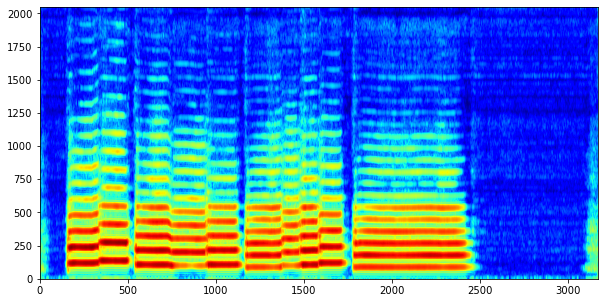

In [11]:
# plot the spectrogram of the generated waveform
spectrogram = tool_lib.spec_amplitude(output_waveform[0].numpy(), fft_bins=4096, frame_shift=40, frame_length=240)
fig=plt.figure()
axis=fig.add_subplot(111)
axis.imshow(spectrogram, aspect='auto', origin='lower', cmap='jet')

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe6a6efab90>)

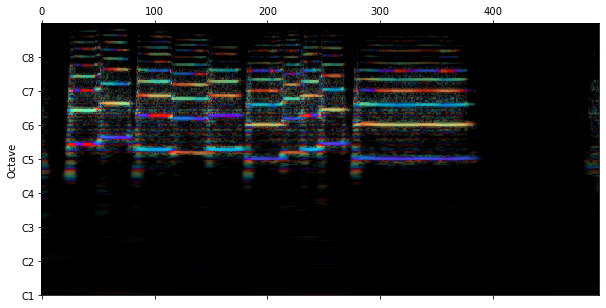

In [12]:
# we can also plot the rainbow gram
fig=plt.figure()
axis=fig.add_subplot(111)
import plot_rainbow
plot_rainbow.plot_rainbow(output_waveform[0].numpy(), sampling_rate, fig, axis)

# 3. Analyzing the hidden signals

Neural filter blocks in NSF models takes 1-dimensional signal as input and produces 1-dimensional signal as output. The skip-connection inside the neural filter blocks allows the neural filter module to gradually transform the source signal into the output signal.

Here we plot the figures for the hidden signals. We uses the buffer inside the `music_nsf_model`


### 3.1 plot hidden signals

'sine-source'

'1st neural filter block'

'2nd neural filter block'

'3rd neural filter block'

'4th neural filter block'

'5th neural filter block (output)'

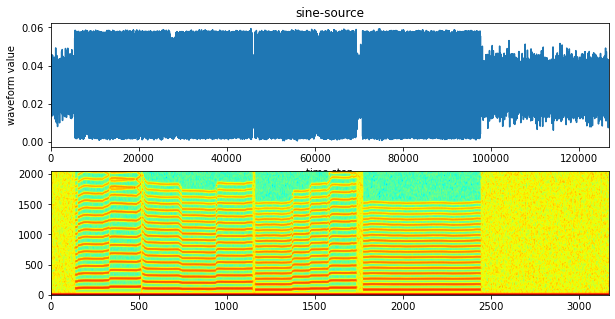

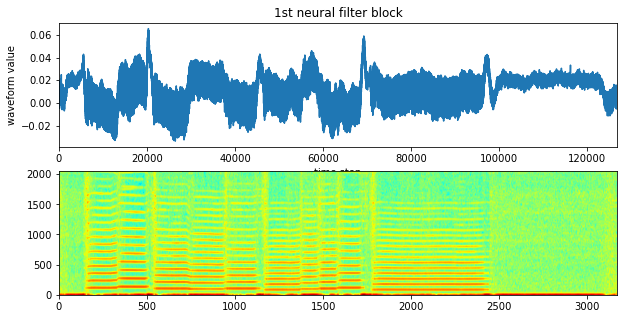

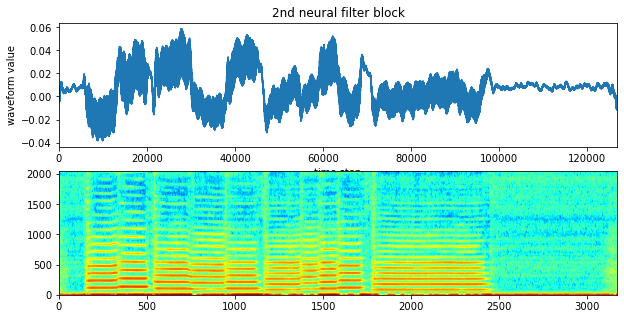

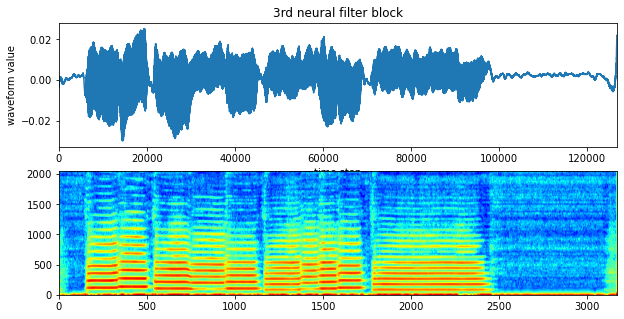

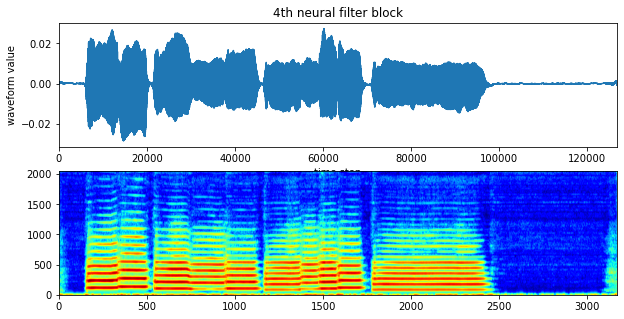

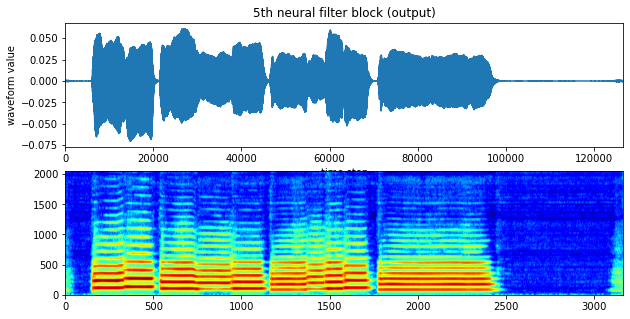

In [13]:
# For harmonic branch
num_signals = len(music_nsf_model.m_filter.hidden_signals_har)
f_spec_function = lambda x: tool_lib.spec_amplitude(x, fft_bins=4096, frame_shift=40, frame_length=240)

name_buffer = ['sine-source', '1st neural filter block', '2nd neural filter block', '3rd neural filter block',
               '4th neural filter block', '5th neural filter block (output)']

for idx, (signal, signal_name) in enumerate(zip(music_nsf_model.m_filter.hidden_signals_har, name_buffer)):
    # shape into 1-D array
    signal_tmp = signal[0, :, 0].numpy()
    
    fig = plt.figure()
    axis = fig.add_subplot(2, 1, 1)
    plot_lib.plot_signal(signal_tmp, fig, axis, 'time step', 'waveform value', signal_name)
    
    spec = f_spec_function(signal_tmp)
    axis = fig.add_subplot(2, 1, 2)
    axis.imshow(spec, aspect='auto', origin='lower', cmap='jet')
    IPython.display.display(signal_name)
    IPython.display.display(IPython.display.Audio(signal_tmp, rate=sampling_rate, normalize=False))

# 4. Mixing audios

The database for training the Music NSF was [URMP](http://www2.ece.rochester.edu/projects/air/projects/URMP.html).
Each data sample contains only one instrument, extracted from a music ensemble. 

We can generate multiple data sample from one test ensemble and merge them back.

Generating multiple data may some time on CPU.

In [14]:
data_list = ['AuSep_1_tpt_43_Chorale_1', 'AuSep_3_hn_43_Chorale_1', 'AuSep_5_tba_43_Chorale_1', 
             'AuSep_2_tpt_43_Chorale_1', 'AuSep_4_tbn_43_Chorale_1']
output_buffer = []
with torch.no_grad():
    for data_name in data_list:
        print("Generating %s" % (data_name))
        input_mel = tool_lib.read_raw_mat("data_models/acoustic_features/music_nsf/%s.mfbsp" % (data_name), mel_dim)
        input_f0 = tool_lib.read_raw_mat("data_models/acoustic_features/music_nsf/%s.f0" % (data_name), f0_dim)
        
        input_length = min([input_mel.shape[0], input_f0.shape[0]])
        input_tensor = torch.zeros(1, input_length, mel_dim + f0_dim, dtype=torch.float32)
        input_tensor[0, :, 0:mel_dim] = torch.tensor(input_mel[0:input_length, :])
        input_tensor[0, :, mel_dim:] = torch.tensor(input_f0[0:input_length]).unsqueeze(-1)
        output_waveform = music_nsf_model(input_tensor)
        output_buffer.append(output_waveform)

Generating AuSep_1_tpt_43_Chorale_1
Generating AuSep_3_hn_43_Chorale_1
Generating AuSep_5_tba_43_Chorale_1
Generating AuSep_2_tpt_43_Chorale_1
Generating AuSep_4_tbn_43_Chorale_1


In [15]:
# create a mixed stereo audio
# put two signals in left channel, put other signals in right channel
mixed_audio = np.zeros([2, output_buffer[0].shape[1]])
mixed_audio[0, :] += output_buffer[0][0].numpy()
mixed_audio[0, :] += output_buffer[1][0].numpy()
mixed_audio[1, :] += output_buffer[2][0].numpy()
mixed_audio[1, :] += output_buffer[3][0].numpy()
mixed_audio[1, :] += output_buffer[4][0].numpy()

import IPython.display
IPython.display.Audio(mixed_audio, rate=sampling_rate, normalize=False)

The end